![tutorialpromo](images/tutorial_banner.PNG)

# Tutorial 4 - PV Module Performance

Now that we know how to obtain the plane of array (POA) irradiance and cell temperature, let's calculate a module's performance assuming a subset of irradiance and temperature conditions. The objectives for this tutorial are to use pvlib python to do the following:

1. Retrieve a set of module CEC parameters from the latest [NREL System Advisor Model (SAM)](https://sam.nrel.gov/) library.
2. Calculate the single diode model (SDM) parameters at standard test conditions (STC) and for a set of PV module test conditions known as IEC61853.
3. Produce an IV curve for each of the IEC61853 test conditions.
4. Derive the California Energy Commission (CEC) model parameters based on standard CEC test measurements.

![Overview](images/tutorial_4_overview.PNG)

####  PV Concepts:

- STC Parameters
- IV Curve
- PV module energy conversion models
    - Point Models
        - [PVWatts](https://pvwatts.nrel.gov/)
        - [Sandia Array Performance Model (SAPM)](https://energy.sandia.gov/wp-content/gallery/uploads/043535.pdf)
    - Continuous Models
        - CEC
        - [PVSyst](https://www.pvsyst.com/)
        - [DeSoto](https://doi.org/10.1016/j.solener.2005.06.010)
- Low light and temperature module performance
- IEC 61853 standard 

#### Python Concepts:

- `numpy.meshgrid`
- `try: except` clauses to catch errors
- Transpose a Pandas dataframe
- string filters: _e.g._ `.str.startswith`
- calling a web API


## Standard Test Conditions (STC)

The most basic condition is called "standard test conditions" or STC, which is considered the reference for most PV modules. For example, all of the PV modules in the SAM CEC module database list their nameplate power at STC.
* irradiance: 1000-W/m&sup2;
* cell temperature: 25&deg;C
* angle of incidence (AOI): 0&deg;
* spectrum: AM1.5g (ASTM G-173)

### Air mass (AM)

The standard reference AM1.5g (ASTM G-173) is defined as the solar spectrum of global irradiance that passes through 1.5 atmospheres. For more information see [NREL Solar Spectra](https://www.nrel.gov/grid/solar-resource/spectra.html).

## IEC 61853 test conditions

Another common set of test conditions is the IEC 61853 standard which provides a PV module test matrix that covers the expected range of inicident irradiance and cell temperatures for PV modules assuming that the irradiance is normal and the solar spectrum is similar to AM1.5g.

* irradiance (W/m&sup2;): 100, 200, 400, 600, 800, 1000, 1100
* module temperature (&deg;C): 15, 25, 50, 75
* angle of incidence: 0&deg;
* spectrum: AM1.5g (ASTM G-173)

The figure below shows IEC 61853 test results performed at CFV labs:

![Overview](images/t4_PANOverview.PNG)

Certain combinations are excluded because they're unlikely: (1100-W/m&sup2;, 15&deg;C), (400-W/m&sup2;, 75&deg;C), (200-W/m&sup2;, 50&deg;C), (200-W/m&sup2;, 75&deg;C), (100-W/m&sup2;, 50&deg;C), and (100-W/m&sup2;, 75&deg;C). The figure below shows SAM parametrs fit to IEC61853 test results for two different cell technologies. The white space shows combinations of irradiance and temperature which were intentionally excluded from testing.

![Overview](images/t4_SingleDiodeParameterBehavior_to_TemperatureandIrradiance.PNG)

Attribution: [NREL Dobos, Freeman 2019](https://www.nrel.gov/docs/fy19osti/68637.pdf)

In [1]:
# import pvlib and other useful python packages
import pvlib
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
# set STC reference conditions
E0 = 1000  # W/m^2
T0 = 25  # degC

# set the IEC61853 test matrix
E_IEC61853 = [100, 200, 400, 600, 800, 1000, 1100]  # irradiances [W/m^2]
T_IEC61853 = [15, 25, 50, 75]                       # temperatures [degC]
IEC61853 = np.meshgrid(T_IEC61853, E_IEC61853)
# display temperature and irradiance test matrix
list(zip(*IEC61853))

[(array([15, 25, 50, 75]), array([100, 100, 100, 100])),
 (array([15, 25, 50, 75]), array([200, 200, 200, 200])),
 (array([15, 25, 50, 75]), array([400, 400, 400, 400])),
 (array([15, 25, 50, 75]), array([600, 600, 600, 600])),
 (array([15, 25, 50, 75]), array([800, 800, 800, 800])),
 (array([15, 25, 50, 75]), array([1000, 1000, 1000, 1000])),
 (array([15, 25, 50, 75]), array([1100, 1100, 1100, 1100]))]

# Single Diode Model (SDM) & IV Curve

PV module performance can be modeled using *point* or *continuous* IV-curve models. 

Point models like PVWatts and The Sandia Array Performance Model (SAPM, _aka_ King model) yield the current (I), voltage (V), and power (P) at a single or discrete set of points. 
PVWatts only yields the performance at the max power point (MPP) of the module, whereas the SAPM also yields the short circuit current (Isc), open circuit voltage (Voc).

Continuous IV curve models like the CEC, PVsyst, and DeSoto models yield a relation between current and voltage called an IV curve, and therefore yield a continuous set of (V, I) points spanning from Isc to Voc and beyond. The domain of the IV curve is in quadrants 1, 2, and 4 where voltage is on the horizontal and current is on the vertical axis. The figure below from [PV Education PVCDROM](https://www.pveducation.org/pvcdrom/welcome-to-pvcdrom) shows an IV curve of an "ideal" cell.

[![IV curve](https://www.pveducation.org/sites/default/files/PVCDROM/Modules/Images/NONIDEAL.gif)](https://www.pveducation.org/pvcdrom/modules-and-arrays/mismatch-effects)

Attribution: [PV Education, UNSW, ASU, _et al._](https://www.pveducation.org/pvcdrom/modules-and-arrays/mismatch-effects)

The IV curve relationship is based on an electrical analog called the "single diode model" or SDM which is defined by 5 parameters: the light current ($I_L$), shunt resistance ($R_{sh}$), series resistance ($R_s$), diode saturation current ($I_o$ or $I_{sat}$), and the diode ideality factor ($n$). Other symbols for diode ideality factor are ($\gamma$) used by PVsyst and ($a$) used by SAM, but ($\gamma$) is also frequently used for power temperature coefficient. This "ideal" cell is described by the electrical schematic drawing below.

[![single diode model](https://pvpmc.sandia.gov/wp-content/uploads/2012/04/Single-Diode-EC2.png)](https://pvpmc.sandia.gov/modeling-steps/2-dc-module-iv/diode-equivalent-circuit-models/)

Attribution: [Sandia NL PV Performance Modeling Collaborative](https://pvpmc.sandia.gov/modeling-steps/2-dc-module-iv/diode-equivalent-circuit-models/)

Combining the components in the SDM using Ohm's and Kirchhoff's laws yields the following equation, which is implicit because current (I) is on both sides of the equation, and cannot be solved explicitly:

$$ I = I_L - I_o \left( \exp \left( \frac{V + I R_s}{n V_T} \right) - 1 \right) - \frac{V + I R_s}{R_{sh}} $$

with the diode voltage ($V_D = V + I R_s$), the diode current ($I_D$) given by the ideal diode equation:

$$ I_D = I_o \left( \exp \left( \frac{V_D}{n V_T} \right) - 1 \right) $$

the thermal voltage ($V_T = k_T / q_e$), elementary charge ($q_e$), Boltzmann constant ($k_T$), and the shunt current ($I_{sh} = V_D / R_{sh}$)

## CEC Model (_aka_ SAM or 6-parameter model)

The California Energy Commision (CEC) contracted authorized testing labs to measure at STC the nameplate power (Pmp), Isc, Voc, and the MPP voltage and current (Vmp, Imp), as well as Isc and Voc temperature coefficients, the module dimensions, the number of series cells (Ns), parallel substrings (Np), module area in m&sup2; (Ac), and more. Tables of the CEC module parameters are available from the [Solar Equipment Lists](https://www.energy.ca.gov/programs-and-topics/programs/solar-equipment-lists). These measurements have been fit to the SDM by the NREL System Advisor Model (SAM) and stored in a CSV file that is bundled with SAM. You can access the [SAM library on GitHub](https://github.com/NREL/SAM/tree/develop/deploy/libraries). This SAM library of module coefficients derived from the CEC measurements are collectively called CEC modules and the SAM model that uses the derived SDM coefficients is called the CEC model. The CEC model used in SAM is sometimes also called the 6-parameter model because of the `Adjust` additional parameter which differentiates it from the DeSoto model.

### pvlib python

There are several functions we can use in pvlib python:

* [`pvlib.pvsystem.retrieve_sam()`](https://pvlib-python.readthedocs.io/en/latest/generated/pvlib.pvsystem.retrieve_sam.html#pvlib.pvsystem.retrieve_sam)
* [`pvlib.pvsystem.calcparams_cec()`](https://pvlib-python.readthedocs.io/en/latest/generated/pvlib.pvsystem.calcparams_cec.html)
* [`pvlib.pvsystem.singlediode()`](https://pvlib-python.readthedocs.io/en/latest/generated/pvlib.pvsystem.singlediode.html)
* [`pvlib.ivtools.sdm.fit_cec_sam()`](https://pvlib-python.readthedocs.io/en/latest/generated/pvlib.ivtools.sdm.fit_cec_sam.html)

In [3]:
# use pvlib python to retrieve CEC module parameters from the SAM libraries
# with the "name" argument set to "CECMod"
CECMODS = pvlib.pvsystem.retrieve_sam(name='CECMod')

# the CEC modules are a pandas DataFrame oriented as columns, transpose to arrange
# as indices
CECMODS.T.head()

,Technology,Bifacial,STC,PTC,A_c,Length,Width,N_s,I_sc_ref,V_oc_ref,...,a_ref,I_L_ref,I_o_ref,R_s,R_sh_ref,Adjust,gamma_r,BIPV,Version,Date
A10Green_Technology_A10J_S72_175,Mono-c-Si,0,175.0914,151.2,1.3,1.576,0.825,72,5.17,43.99,...,1.981696,5.175703,0.0,0.316688,287.102203,16.057121,-0.5072,N,SAM 2018.11.11 r2,1/3/2019
A10Green_Technology_A10J_S72_180,Mono-c-Si,0,179.928,155.7,1.3,1.576,0.825,72,5.31,44.06,...,1.988414,5.316148,0.0,0.299919,259.047943,16.418983,-0.5072,N,SAM 2018.11.11 r2,1/3/2019
A10Green_Technology_A10J_S72_185,Mono-c-Si,0,184.7016,160.2,1.3,1.576,0.825,72,5.43,44.14,...,1.984817,5.435676,0.0,0.311962,298.424438,15.688233,-0.5072,N,SAM 2018.11.11 r2,1/3/2019
A10Green_Technology_A10J_M60_220,Multi-c-Si,0,219.876,189.1,1.624,1.632,0.995,60,7.95,36.06,...,1.673094,7.959062,0.0,0.140393,123.168404,21.875164,-0.5196,N,SAM 2018.11.11 r2,1/3/2019
A10Green_Technology_A10J_M60_225,Multi-c-Si,0,224.9856,193.5,1.624,1.632,0.995,60,8.04,36.24,...,1.671782,8.047206,0.0,0.14737,164.419479,20.698376,-0.5196,N,SAM 2018.11.11 r2,1/3/2019


### CEC modules library

Periodically a static copy of CEC module parametres is copied from the SAM library to pvlib python. The modules are roughly named according the following scheme:

    <manufacturer name> <model name>

Whitespace, dashes, and other non-alphanumerical characters are all replaced by underscores in pvlib python.

EG: "Canadian Solar Inc. CS6X-300M" becomes

    Canadian_Solar_Inc__CS6X_300M
    

<div class="alert alert-block alert-info">
<b>Let's Explore:</b> <a href='https://www.ecodirect.com/Canadian-Solar-CS6X-300M-300W-36V-PV-Panel-p/canadian-solar-cs6x-300m.htm'> Click here to see the panel's Datasheet. </a></div>


The main CEC module parameters are defined as follows:

| parameter    | data type | description and units                                                                         |
| ------------ | --------- | --------------------------------------------------------------------------------------------- |
| `Technology` | string    | one of "Mono-c-Si", "Multi-c-Si", "Thin Film", "CdTe", or "CIGS" families of cells            |
| `Bifacial`   | boolean   | is bifacial?                                                                                  |
| `STC`        | float     | nameplate in W at STC                                                                         |
| `PTC`        | float     | nameplate in W at PVUSA test conditions (1-sun, 20&deg; ambient temperature, 1-m/s windspeed) |
| `A_c`        | float     | module area in m&sup2;                                                                        |
| `Length`     | float     | module length in m;                                                                           |
| `Width`      | float     | module width in m;                                                                            |
| `N_s`        | int       | number of cells in series                                                                     |
| `I_sc_ref`   | float     | short circuit current in A at reference condition                                             |
| `V_oc_ref`   | float     | open circuit voltage in V at reference condition                                              |
| `I_mp_ref`   | float     | max power current in A at reference condition                                                 |
| `V_mp_ref`   | float     | max power voltage in V at reference condition                                                 |
| `alpha_sc`   | float     | short circuit current temperature coefficient in A/&Delta;&deg;C                              |
| `beta_oc`    | float     | open circuit voltage temperature coefficient in V/&Delta;&deg;C                               |
| `T_NOCT`     | float     | normal operating cell temperature in &deg;C                                                   |
| `a_ref`      | float     | diode ideality factor                                                                         |
| `I_L_ref`    | float     | light or photogenerated current at reference condition in A                                   |
| `I_o_ref`    | float     | diode saturation current at reference condition in A                                          |
| `R_s`        | float     | series resistance in &Omega;                                                                  |
| `R_sh_ref`   | float     | shunt resistance at reference condition in &Omega;                                            |
| `Adjust`     | float     | adjustment to short circuit temperature coefficient in %                                      |
| `gamma_r`    | float     | power temperature coefficient at reference condition in %/&Delta;&deg;C                       |
| `BIPV`       | boolean   | is building integrated PV?                                                                    |

In [4]:
# One trick to find the modules is to search the indices using string filters
# For example: find all Candian Solar 220-W mono-Si modules
cs_220m_mods = CECMODS.T.index.str.startswith('Canadian_Solar') & CECMODS.T.index.str.contains('220M')
CECMODS.T[cs_220m_mods]

,Technology,Bifacial,STC,PTC,A_c,Length,Width,N_s,I_sc_ref,V_oc_ref,...,a_ref,I_L_ref,I_o_ref,R_s,R_sh_ref,Adjust,gamma_r,BIPV,Version,Date
Canadian_Solar_Inc__CS5P_220M,Mono-c-Si,0,219.961,200.1,1.7,1.602,1.061,96,5.1,59.4,...,2.635926,5.11426,0.0,1.066023,381.254425,8.619516,-0.476,N,SAM 2018.11.11 r2,1/3/2019
Canadian_Solar_Inc__CS6P_220M,Mono-c-Si,0,219.775,198.5,1.549,1.615,0.959,60,7.97,36.9,...,1.515583,7.980784,0.0,0.397651,293.871094,-3.311191,-0.436,N,SAM 2018.11.11 r2,1/3/2019


In [5]:
# that was almost too easy, let's use the CS5P-220M
# NOTE: don't transpose CECMODS, get column with desired module 
CS_220M = CECMODS['Canadian_Solar_Inc__CS5P_220M']
CS_220M

Technology            Mono-c-Si
Bifacial                      0
STC                     219.961
PTC                       200.1
A_c                         1.7
Length                    1.602
Width                     1.061
N_s                          96
I_sc_ref                    5.1
V_oc_ref                   59.4
I_mp_ref                   4.69
V_mp_ref                   46.9
alpha_sc               0.004539
beta_oc               -0.222156
T_NOCT                     42.4
a_ref                  2.635926
I_L_ref                 5.11426
I_o_ref                     0.0
R_s                    1.066023
R_sh_ref             381.254425
Adjust                 8.619516
gamma_r                  -0.476
BIPV                          N
Version       SAM 2018.11.11 r2
Date                   1/3/2019
Name: Canadian_Solar_Inc__CS5P_220M, dtype: object

### Pop Quiz #1

Get any CEC module from the `CECMODS` or pvfree.

* Which module did you get?
* How did you get it?
* What is the module's nameplate power, Isc, Voc, Imp, and Vmp?
* Who is the manufacturer?
* What cell technology is it?
* How does it differ from CS5P-220M?

In [6]:
# use this cell to search CECMODS.T or pvfree
your_mod = 'your module goes here'
try:
    your_mod = CECMODS[your_mod]
except KeyError:
    print(f"*** Sorry, '{your_mod}' wasn't found in CECMODS. Please try again. ***")
else:
    # display your module
    your_mod

*** Sorry, 'your module goes here' wasn't found in CECMODS. Please try again. ***


# Calculate CEC Parameters

The module parameters are given at the reference condition. Use [`pvlib.pvsystem.calcparams_cec()`](https://pvlib-python.readthedocs.io/en/latest/generated/pvlib.pvsystem.calcparams_cec.html) to generate the five SDM parameters at your desired irradiance and temperature to use with [`pvlib.pvsystem.singlediode()`](https://pvlib-python.readthedocs.io/en/latest/generated/pvlib.pvsystem.singlediode.html) to calculate the IV curve information.

### `nNsVth`, what's this?

The diode ideality factor (n) is combined with the number of cells (Ns) and the thermal voltage (Vth) to create a convenience parameter. This is [syntactic sugar](https://en.wikipedia.org/wiki/Syntactic_sugar).

In [7]:
# finally this is the magic
temp_cell, effective_irradiance = IEC61853
cecparams = pvlib.pvsystem.calcparams_cec(
        effective_irradiance=effective_irradiance,
        temp_cell=temp_cell,
        alpha_sc=CS_220M.alpha_sc,
        a_ref=CS_220M.a_ref,
        I_L_ref=CS_220M.I_L_ref,
        I_o_ref=CS_220M.I_o_ref,
        R_sh_ref=CS_220M.R_sh_ref,
        R_s=CS_220M.R_s,
        Adjust=CS_220M.Adjust,
        EgRef=1.121,
        dEgdT=-0.0002677)
IL, I0, Rs, Rsh, nNsVth = cecparams
# display the photogenerated current
IL

array([[0.50727824, 0.511426  , 0.5217954 , 0.5321648 ],
       [1.01455648, 1.022852  , 1.0435908 , 1.0643296 ],
       [2.02911296, 2.045704  , 2.0871816 , 2.1286592 ],
       [3.04366944, 3.068556  , 3.1307724 , 3.19298881],
       [4.05822592, 4.091408  , 4.1743632 , 4.25731841],
       [5.0727824 , 5.11426   , 5.217954  , 5.32164801],
       [5.58006064, 5.625686  , 5.7397494 , 5.85381281]])

## IV Curve Info

Now that we have the 5 SDM parameters (`IL`, `Io`, `Rs`, `Rsh`, and `nNsVth`) corresponding to each of the test conditions in the IEC61853 test matrix, we can calculate the IV curve information for that irradiance and cell temperature.

In [8]:
# flatten the meshgrid to allow single diode to broadcast the output
curve_info = pvlib.pvsystem.singlediode(
    photocurrent=IL.flatten(),
    saturation_current=I0.flatten(),
    resistance_series=Rs,
    resistance_shunt=Rsh.flatten(),
    nNsVth=nNsVth.flatten(),
    ivcurve_pnts=101,
    method='lambertw')
# display the max power points
curve_info['p_mp']

array([ 22.47343394,  21.33361989,  18.40248885,  15.37301683,
        46.09149166,  43.8742866 ,  38.16845408,  32.26328096,
        93.53042326,  89.21121134,  78.09399194,  66.58417955,
       140.31155148, 133.92211282, 117.4814962 , 100.47025604,
       186.01690382, 177.57186861, 155.8544359 , 133.40606247,
       230.45392244, 219.96093865, 192.99618253, 165.16041729,
       252.16127408, 240.6459279 , 211.06605369, 180.55357125])

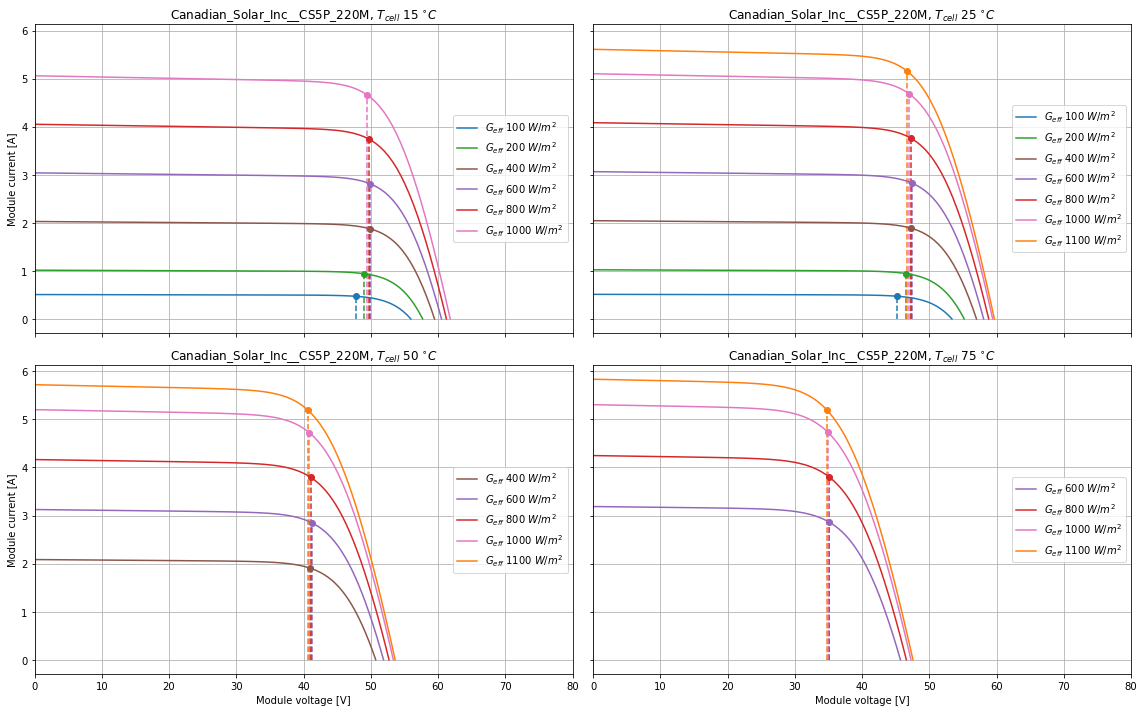

In [9]:
# plot the calculated curves:
exclude = [(1100, 15), (400, 75), (200, 50), (200, 75), (100, 50), (100, 75)]
kolor = ['#1f77b4', '#2ca02c', '#8c564b', '#9467bd', '#d62728', '#e377c2', '#ff7f0e']
f, ax = plt.subplots(2, 2, figsize=(16, 10), sharex=True, sharey=True)
for m, irr in enumerate(E_IEC61853):
    for n, tc in enumerate(T_IEC61853):
        if (irr, tc) in exclude:
            continue
        i = n + 4*m
        j = n // 2, n % 2
        label = (
            "$G_{eff}$ " + f"{irr} $W/m^2$"
        )
        ax[j].plot(curve_info['v'][i], curve_info['i'][i], label=label, c=kolor[m])
        v_mp = curve_info['v_mp'][i]
        i_mp = curve_info['i_mp'][i]
        # mark the MPP
        ax[j].plot(v_mp, i_mp, ls='', marker='o', c=kolor[m])
        ax[j].vlines(v_mp, 0, i_mp, linestyle='dashed', color=kolor[m])
        # just repeat this every time doesn't hurt anyone
        ax[j].legend(loc='right')
        if j[0] == 1:
            ax[j].set_xlabel('Module voltage [V]')
        if j[1] == 0:
            ax[j].set_ylabel('Module current [A]')
        ax[j].set_title(f"{CS_220M.name}, " + "$T_{cell}$ " + f"{tc} " + "$^{\circ}C$")
        ax[j].grid(True)
        ax[j].set_xlim([0, 80])

f.tight_layout()

## Conclusions

So is this what you expected? What do you notice about the relation between voltage and temperature? What about the relation between current and irradiance? What other patterns do you observe

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.